# Anlisis aleatorio creación indice

## Librerías

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup




### Funciones de docs en repositorio
from Funciones import calculate_metrics

## Información inicial

In [ ]:

START_DATE = "2025-01-01"

## Como crear un indices específico personalizado con pesos automáticos

Pesos dentro del índice:
AAPL: 21.6887%
MSFT: 22.1934%
GOOGL: 16.9690%
AMZN: 13.4777%
NVDA: 25.6712%
Total: 100.0000% /n


[*********************100%***********************]  6 of 6 completed


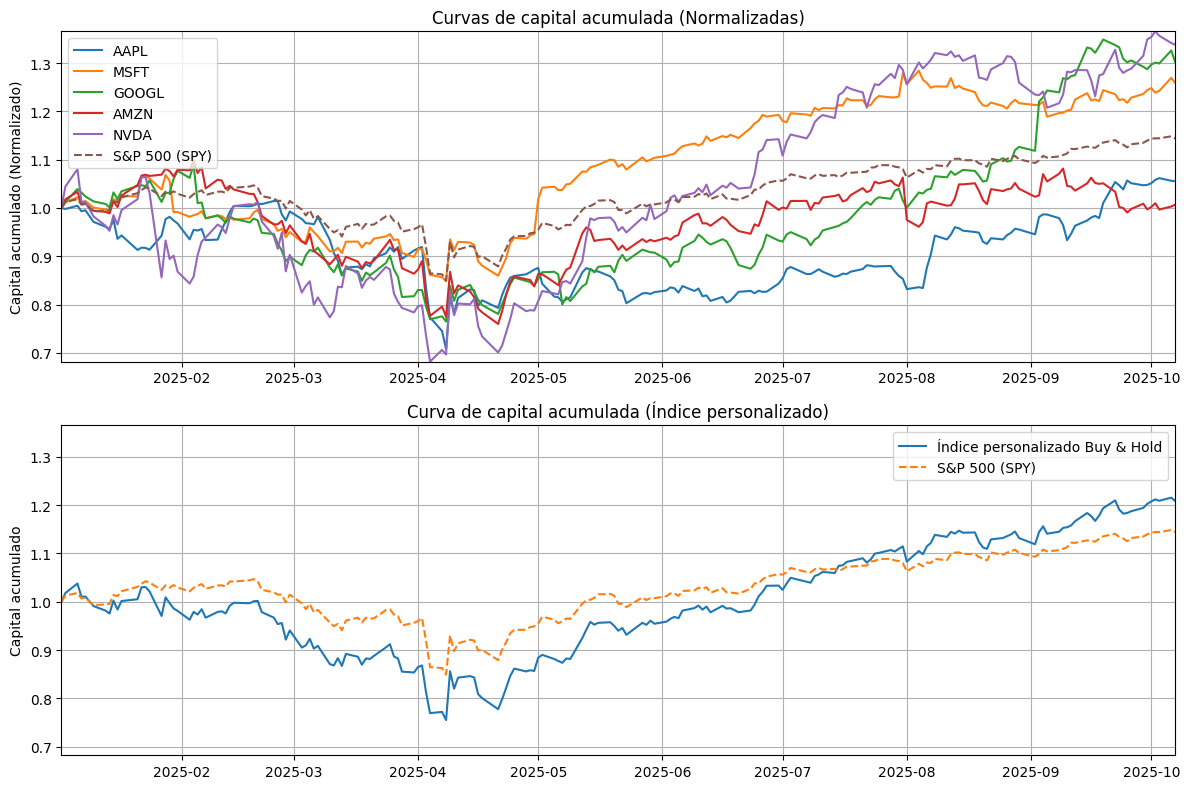

In [8]:
# Lista de algunos tickers del S&P 500 (puedes ampliarla con todos los componentes)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']

# Diccionario para guardar capitalizaciones
market_caps = {}

# Obtener capitalización de cada empresa
for ticker in tickers:
    info = yf.Ticker(ticker).info
    market_caps[ticker] = info['marketCap']

# Calcular capitalización total del índice
total_market_cap = sum(market_caps.values())
tot=0
# Calcular y mostrar el peso de cada empresa
print("Pesos dentro del índice:")
for ticker, cap in market_caps.items():
    weight = cap / total_market_cap
    tot+=weight
    print(f"{ticker}: {weight:.4%}")
print(f"Total: {tot:.4%}", "/n")



weights = {ticker: cap / total_market_cap for ticker, cap in market_caps.items()}

#Descargar precios históricos
data = yf.download(tickers+ ['^GSPC'], start=START_DATE, auto_adjust=True)['Close']
#Normalizar precios (todos empiezan en 1)
normalized = data / data.iloc[0]

# Aplicar pesos y sumar para formar el índice
custom_index = pd.Series(0, index=normalized.index)
for ticker in tickers:
    custom_index += normalized[ticker] * weights[ticker]

# Normalizar SPY para comparación
spy_curve = normalized['^GSPC']
# Sincronizar límites de los ejes x e y para ambas gráficas
xlim = [normalized.index[0], normalized.index[-1]]
ylim = [
    min(normalized.min().min(), custom_index.min()),
    max(normalized.max().max(), custom_index.max())
]


# Graficar comparación
plt.figure(figsize=(12,8))
# Graficar cada ticker en una gráfica con límites sincronizados
plt.subplot(2,1,1)
for ticker in tickers:
    plt.plot(normalized[ticker], label=ticker)
plt.plot(spy_curve, label='S&P 500 (SPY)', linestyle='--')
plt.title('Curvas de capital acumulada (Normalizadas)')
plt.ylabel('Capital acumulado (Normalizado)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xlim(xlim)
plt.ylim(ylim)


# Graficar curva Buy & Hold personalizada con límites sincronizados
plt.subplot(2,1,2)
plt.plot(custom_index, label='Índice personalizado Buy & Hold')
plt.plot(spy_curve, label='S&P 500 (SPY)', linestyle='--')
plt.title('Curva de capital acumulada (Índice personalizado)')
plt.ylabel('Capital acumulado')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()
plt.show()

## Aleatorio con tickers S&P 500

### Sacar tickers s&p 500 actual

In [11]:
# URL de la lista del S&P 500
url = "https://www.slickcharts.com/sp500"


# Hacer la petición con headers para evitar bloqueos
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
}
response = requests.get(url, headers=headers)
response.raise_for_status()  # Raise exception for bad status codes

# Parsear el HTML
soup = BeautifulSoup(response.text, 'html.parser')

# Encontrar la tabla
table = soup.find('table')

if table:
    # Leer la tabla con pandas
    df = pd.read_html(str(table))[0]
    
    # Extraer los tickers
    if 'Symbol' in df.columns:
        tickers = df['Symbol'].tolist()
        print(f"Found {len(tickers)} tickers")
        print("First 10 tickers:", tickers[:10])
    else:
        print("Available columns:", df.columns.tolist())

    # Extraer los pesos
    if 'Weight' in df.columns:
        weights = df['Weight'].tolist()
        print(f"Found {len(weights)} weights")
        print("First 10 weights:", weights[:10])
    else:
        print("Available columns:", df.columns.tolist())
else:
    print("No table found on the page")

# En la lista de ticker, reemplazar los "." por "-"
tickers = [ticker.replace('.', '-') for ticker in tickers]
print("Tickers after replacement:", tickers[:10])

Found 503 tickers
First 10 tickers: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'GOOG', 'TSLA', 'BRK.B']
Found 503 weights
First 10 weights: ['7.42%', '6.41%', '6.27%', '3.89%', '2.95%', '2.62%', '2.53%', '2.38%', '2.37%', '1.78%']
Tickers after replacement: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'GOOG', 'TSLA', 'BRK-B']


C:\Users\a01286222\AppData\Local\Temp\ipykernel_36464\2475046699.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


### Cálculo de indices aleatorios

In [13]:
# -----------------------------
# 0. Parámetros de simulación
# -----------------------------
NUM_COMBINATIONS = 100       # Número de combinaciones a probar
NUM_TICKERS_PER_INDEX = 10  # Número de acciones por índice


In [ ]:
# -----------------------------
# 1. Descargar precios históricos
# -----------------------------
data = yf.download(tickers, start=START_DATE, auto_adjust=True)['Close']
data = data.dropna(axis=1)  # eliminar columnas con datos faltantes


'''# -----------------------------
# 2. Función para calcular métricas
# -----------------------------
def calculate_metrics(curve, risk_free_rate=0.01):
    returns = curve.pct_change().dropna()
    years = (curve.index[-1] - curve.index[0]).days / 365.25
    cagr = (curve.iloc[-1] / curve.iloc[0]) ** (1 / years) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe = (cagr - risk_free_rate) / volatility if volatility != 0 else np.nan
    rolling_max = curve.cummax()
    drawdown = curve / rolling_max - 1
    max_dd = drawdown.min()
    return cagr, volatility, sharpe, max_dd'''

[*********************100%***********************]  503 of 503 completed


In [17]:
# -----------------------------
# 3. Simulación de combinaciones
# -----------------------------
results = []

for i in range(NUM_COMBINATIONS):
    subset = random.sample(list(data.columns), NUM_TICKERS_PER_INDEX)

    # Obtener capitalizaciones y calcular pesos
    market_caps = {}
    for ticker in subset:
        try:
            info = yf.Ticker(ticker).info
            market_caps[ticker] = info['marketCap']
        except:
            market_caps[ticker] = 1  # fallback si falla

    total_cap = sum(market_caps.values())
    weights = {ticker: market_caps[ticker] / total_cap for ticker in subset}

    # Normalizar precios
    normalized = data[subset] / data[subset].iloc[0]

    # Construir índice personalizado
    index_curve = sum(normalized[t] * weights[t] for t in subset)

    # Calcular métricas
    cagr, vol, sharpe, dd = calculate_metrics(index_curve)
    results.append({
        'tickers': subset,
        'weights': weights,
        'curve': index_curve,
        'CAGR': cagr,
        'Volatility': vol,
        'Sharpe': sharpe,
        'Drawdown': dd
    })

# -----------------------------
# 4. Seleccionar el mejor índice
# -----------------------------
best = max(results, key=lambda x: x['Sharpe'])


In [18]:
Mags = yf.download('MAGS', start=START_DATE, auto_adjust=True)['Close']
SPY = yf.download('SPY', start=START_DATE, auto_adjust=True)['Close']
Nasdaq = yf.download('^IXIC', start=START_DATE, auto_adjust=True)['Close']
Mags_curve = Mags / Mags.iloc[0]
SPY_curve = SPY / SPY.iloc[0]
Nasdaq_curve = Nasdaq / Nasdaq.iloc[0]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


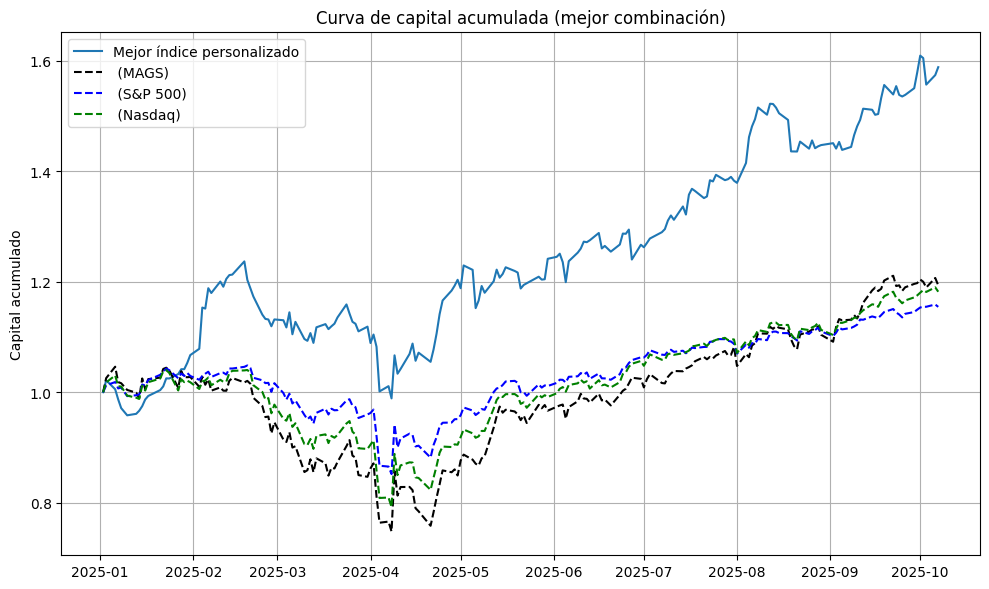


📈 Mejor combinación de acciones:
TROW, TXT, PLTR, BLDR, JNJ, MSI, BALL, ABBV, COF, TECH

📊 Métricas:
CAGR: 83.69%
Volatilidad: 28.28%
Sharpe Ratio: 2.92
Max Drawdown: -20.05%


In [19]:
# -----------------------------
# 5. Graficar el mejor índice
# -----------------------------
plt.figure(figsize=(10,6))
plt.plot(best['curve'], label='Mejor índice personalizado')
plt.plot(Mags_curve, label=' (MAGS)', linestyle='--', color='black')
plt.plot(SPY_curve, label=' (S&P 500)', linestyle='--', color='blue')
plt.plot(Nasdaq_curve, label=' (Nasdaq)', linestyle='--', color='green')
plt.title('Curva de capital acumulada (mejor combinación)')
plt.ylabel('Capital acumulado')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 6. Mostrar métricas
# -----------------------------
print("\n📈 Mejor combinación de acciones:")
print(", ".join(best['tickers']))
print("\n📊 Métricas:")
print(f"CAGR: {best['CAGR']:.2%}")
print(f"Volatilidad: {best['Volatility']:.2%}")
print(f"Sharpe Ratio: {best['Sharpe']:.2f}")
print(f"Max Drawdown: {best['Drawdown']:.2%}")

In [20]:
top10 = sorted(results, key=lambda x: x['Sharpe'], reverse=True)[:10]

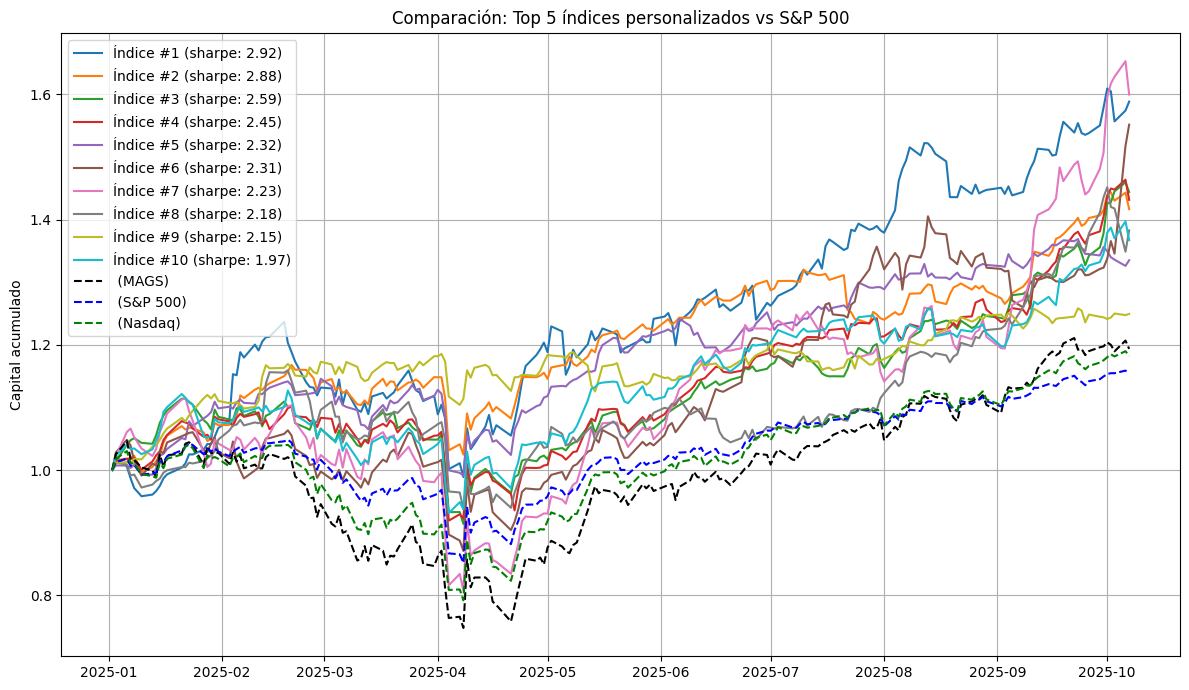

In [21]:
plt.figure(figsize=(12,7))
for i, result in enumerate(top10):
    plt.plot(result['curve'], label=f'Índice #{i+1} (sharpe: {result["Sharpe"]:.2f})')
plt.plot(Mags_curve, label=' (MAGS)', linestyle='--', color='black')
plt.plot(SPY_curve, label=' (S&P 500)', linestyle='--', color='blue')
plt.plot(Nasdaq_curve, label=' (Nasdaq)', linestyle='--', color='green')
plt.title('Comparación: Top 5 índices personalizados vs S&P 500')
plt.ylabel('Capital acumulado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------
for i, result in enumerate(top10[:5]):
    print(f"\n🏆 Índice #{i+1}")
    print("Acciones:", ", ".join(result['tickers']))
    print(f"CAGR: {result['CAGR']:.2%}")
    weights_str = ", ".join([f"{ticker}: {weight:.2%}" for ticker, weight in result['weights'].items()])
    print(f"Weights: {weights_str}")
    print(f"Volatilidad: {result['Volatility']:.2%}")
    print(f"Sharpe Ratio: {result['Sharpe']:.2f}")
    print(f"Max Drawdown: {result['Drawdown']:.2%}")